**1. Setup GPU and G-Drive**

Choose a **GPU** runtime and check the device.

In [ ]:
!nvidia-smi

Mount your **google drive**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**2. Build Tensorflow From Source**

Install bazel to build tensorflow from source.

In [ ]:
!sudo apt install curl gnupg
!curl -fsSL https://bazel.build/bazel-release.pub.gpg | gpg --dearmor > bazel.gpg
!sudo mv bazel.gpg /etc/apt/trusted.gpg.d/
!echo "deb [arch=amd64] https://storage.googleapis.com/bazel-apt stable jdk1.8" | sudo tee /etc/apt/sources.list.d/bazel.list
!sudo apt update && sudo apt install bazel
!sudo apt update && sudo apt install bazel-3.1.0

Install the tensorflow pip package **dependencies**.

In [ ]:
!sudo apt install python3-dev python3-pip
!pip install -U --user pip numpy wheel
!pip install -U --user keras_preprocessing --no-deps

**Note:** Restart the runtime in order to use newly installed versions.

Download the latest tensorflow **source** code

In [ ]:
!git clone https://github.com/tensorflow/tensorflow.git
%cd tensorflow

Configure your system build by running the ***./configure*** at the root of your TensorFlow source tree.

In [ ]:
!./configure

**Note:** For GPU support, set cuda=Y and specify the CUDA compute capabilities you want to build with, during configuration.

Build and **install** the package from the master branch.

In [ ]:
!bazel build --config=cuda //tensorflow/tools/pip_package:build_pip_package
!./bazel-bin/tensorflow/tools/pip_package/build_pip_package --nightly_flag /tmp/tensorflow_pkg
!pip install /tmp/tensorflow_pkg/tf_nightly-2.5.0-cp36-cp36m-linux_x86_64.whl

**Note:** The build process can take **several hours** depending on the build and hardware configurations.

Once the build is complete, you can save the '**.whl**' file in your **google drive** and install the it directly from your drive, at a later time without having to rebuild the same.

In [ ]:
!cp /tmp/tensorflow_pkg/tf_nightly-2.5.0-cp36-cp36m-linux_x86_64.whl /content/drive/MyDrive/tf_nigltly_wheel/tf_nightly-2.5.0-cp36-cp36m-linux_x86_64.whl
!pip install /content/drive/MyDrive/tf_nigltly_wheel/tf_nightly-2.5.0-cp36-cp36m-linux_x86_64.whl

**Note:** Here we need to install the latest **nigtly version** since the the **mobilenetv3** architecture is only available in this version.

Restart the kernel and check the tensorflow version. 

In [ ]:
import tensorflow as tf
tf.__version__

**3. Prepare Dataset**

Load and extract the **aisegment** dataset images into local drive.

In [ ]:
!cp /content/drive/MyDrive/AISEGDS/AISEGDS.zip  .
!unzip AISEGDS.zip

**4. Imports**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
import os, cv2, imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

**5. Model Architecture**

In the **decoder** module we use **transition blocks** along with upsampling layers , similar to the decode modules in the portrait-net architecture. There are two branches in this block: one branch contains two **depthwise separable convolutions** and  the other contains a single **1×1 convolution** to adjust the number of channels.

In [4]:
def bottleneck(x, nfilters):

  
  y = DepthwiseConv2D(kernel_size=3, depth_multiplier=1, padding='same')(x)
  y = BatchNormalization()(y)
  y = Activation("relu")(y)
 
  y = Conv2D(kernel_size=1, filters=nfilters, padding ='same')(y)
  y = BatchNormalization()(y)
  y = Activation("relu")(y)


  y = DepthwiseConv2D(kernel_size=3, depth_multiplier=1, padding='same')(y)
  y = BatchNormalization()(y)
  y = Activation("relu")(y)

  y = Conv2D(kernel_size=1, filters=nfilters, padding ='same')(y)
  y = BatchNormalization()(y)
  
  z = Conv2D(kernel_size=1, filters=nfilters, padding ='same')(x)
  z = BatchNormalization()(z)

  z = Add()([y, z])
  z = Activation("relu")(z)

  return z

Here we use minimalistic version of **mobilnetev3** as the encoder part of the network. Use the [mobilenet_v3.py ](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/mobilenet_v3.py)file to load the architecture and weights for the pretrained model. For the decoder part, we use an upsampling block with **bilinear resize** along with the aforementioned transition blocks. In case of **skip connections** between encoder anmd decoder, we use **element-wise addition** instead of concatenation for faster inference speed.

In [ ]:
PRETRAINED='/content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-10-0.03.hdf5'#'/content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-03-0.14.hdf5'

#  Model architecture: mnv3_unet

from mobilenet_v3 import * # Dont forget to remove rescale layer

def mnv3_unet(finetune=False, pretrained=False, alpha=1):

    # Load pretrained model (if any)
    if (pretrained):
       model=load_model(PRETRAINED)
       for layer in model.layers:
        layer.trainable = True  # Unfreeze all layers
       print("Loaded pretrained model ...\n")
       return model

    # Encoder
    mnv3 = MobileNetV3Small(
    input_shape=(256,256,3), alpha=1.0, minimalistic=True, include_top=False,
    weights='imagenet')

    if (finetune):
      for layer in mnv3.layers[:-3]:
        layer.trainable = False
          
    # Decoder
    x = mnv3.layers[-4].output

    x = bottleneck(x, 288)
    #x = Conv2DTranspose(filters=288, kernel_size=3, strides=2, padding = 'same', use_bias=False)(x)
    x = UpSampling2D( size=(2, 2), interpolation='bilinear')(x)
    x = Add()([x, mnv3.layers[74].output])#concatenate([x, mnv3.layers[71].output], axis = 3) # 75 l
    
    x = bottleneck(x, 96)
    #x = Conv2DTranspose(filters=96, kernel_size=3, strides=2, padding = 'same', use_bias=False)(x)
    x = UpSampling2D( size=(2, 2), interpolation='bilinear')(x)
    x = Add()([x, mnv3.layers[30].output]) # 32
                
    x = bottleneck(x, 72)
    #x = Conv2DTranspose(filters=72, kernel_size=3, strides=2, padding = 'same', use_bias=False)(x)
    x = UpSampling2D( size=(2, 2), interpolation='bilinear')(x)
    x = Add()([x, mnv3.layers[12].output]) # 13
    
    x = bottleneck(x, 16)
    #x = Conv2DTranspose(filters=72, kernel_size=3, strides=2, padding = 'same', use_bias=False)(x)
    x = UpSampling2D( size=(2, 2), interpolation='bilinear')(x)
                
    #x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = UpSampling2D( size=(2, 2), interpolation='bilinear')(x)
    x = Conv2D(2, (1,1), padding='same')(x)
    

    model = Model(inputs=mnv3.input, outputs=x)
    
    model.compile(optimizer=Adam(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Ensure you have sparse labels
    
    return model

model=mnv3_unet(finetune=True, pretrained=False, alpha=1)

# Model summary
model.summary()

# Layer specifications
for i, layer in enumerate(model.layers):
    print(i, layer.output.name, layer.output.shape, layer.trainable)


**Note:** The official tf.keras mobilenetv3 architecture contains a '**Rescale**' layer in the network architecture for normalizing input images. However, it was observed that this layer is neither supported by tflite **GPU** delegate nor by tf.keras **quantization** API's. Therefore we remove this layer and directly normalize the images in the dataloader module, before feeding it to the network.

**6. Data Loader And Augmentations**

Use the custom data-loader to perform augmentaion on-the-fly and feed the network with batch of images. Here we use the augmentaion like **brightness, saturation, contrast, cropping, flipping** etc for training the model. The mask images should be **binary** with pixel value **0** representing **background**, and stored in **png** format.

In [6]:
import tensorflow as tf
import random

class DataLoader(object):
    """A TensorFlow Dataset API based loader for semantic segmentation problems."""

    def __init__(self, image_paths, mask_paths, image_size, channels=[3, 3], crop_percent=None, palette=None, seed=None):
        """
        Initializes the data loader object
        Args:
            image_paths: List of paths of train images.
            mask_paths: List of paths of train masks (segmentation masks)
            image_size: Tuple of (Height, Width), the final height 
                        of the loaded images.
            channels: List of ints, first element is number of channels in images,
                      second is the number of channels in the mask image (needed to
                      correctly read the images into tensorflow.)
            crop_percent: Float in the range 0-1, defining percentage of image 
                          to randomly crop.
            palette: A list of RGB pixel values in the mask. If specified, the mask
                     will be one hot encoded along the channel dimension.
            seed: An int, if not specified, chosen randomly. Used as the seed for 
                  the RNG in the data pipeline.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.palette = palette
        self.image_size = image_size
        if crop_percent is not None:
            if 0.0 < crop_percent <= 1.0:
                self.crop_percent = tf.constant(crop_percent, tf.float32)
            elif 0 < crop_percent <= 100:
                self.crop_percent = tf.constant(crop_percent / 100., tf.float32)
            else:
                raise ValueError("Invalid value entered for crop size. Please use an \
                                  integer between 0 and 100, or a float between 0 and 1.0")
        else:
            self.crop_percent = None
        self.channels = channels
        if seed is None:
            self.seed = random.randint(0, 1000)
        else:
            self.seed = seed

    def _corrupt_brightness(self, image, mask):
        """
        Radnomly applies a random brightness change.
        """
        cond_brightness = tf.cast(tf.random.uniform(
            [], maxval=2, dtype=tf.int32), tf.bool)
        image = tf.cond(cond_brightness, lambda: tf.image.random_brightness(
            image, 0.1), lambda: tf.identity(image))
        return image, mask


    def _corrupt_contrast(self, image, mask):
        """
        Randomly applies a random contrast change.
        """
        cond_contrast = tf.cast(tf.random.uniform(
            [], maxval=2, dtype=tf.int32), tf.bool)
        image = tf.cond(cond_contrast, lambda: tf.image.random_contrast(
            image, 0.1, 0.8), lambda: tf.identity(image))
        return image, mask


    def _corrupt_saturation(self, image, mask):
        """
        Randomly applies a random saturation change.
        """
        cond_saturation = tf.cast(tf.random.uniform(
            [], maxval=2, dtype=tf.int32), tf.bool)
        image = tf.cond(cond_saturation, lambda: tf.image.random_saturation(
            image, 0.1, 0.8), lambda: tf.identity(image))
        return image, mask


    def _crop_random(self, image, mask):
        """
        Randomly crops image and mask in accord.
        """
        cond_crop_image = tf.cast(tf.random.uniform(
            [], maxval=2, dtype=tf.int32, seed=self.seed), tf.bool)
        cond_crop_mask = tf.cast(tf.random.uniform(
            [], maxval=2, dtype=tf.int32, seed=self.seed), tf.bool)

        shape = tf.cast(tf.shape(image), tf.float32)
        h = tf.cast(shape[0] * self.crop_percent, tf.int32)
        w = tf.cast(shape[1] * self.crop_percent, tf.int32)

        image = tf.cond(cond_crop_image, lambda: tf.image.random_crop(
            image, [h, w, self.channels[0]], seed=self.seed), lambda: tf.identity(image))
        mask = tf.cond(cond_crop_mask, lambda: tf.image.random_crop(
            mask, [h, w, self.channels[1]], seed=self.seed), lambda: tf.identity(mask))

        return image, mask


    def _flip_left_right(self, image, mask):
        """
        Randomly flips image and mask left or right in accord.
        """
        image = tf.image.random_flip_left_right(image, seed=self.seed)
        mask = tf.image.random_flip_left_right(mask, seed=self.seed)

        return image, mask


    def _resize_data(self, image, mask):
        """
        Resizes images to specified size and normalizes the image: [0...1]
        """
        image = tf.image.resize(image, [self.image_size, self.image_size]) #/255.0
        image = tf.keras.applications.mobilenet.preprocess_input(image) # For mobilnetv3 preprocesing in tf-nightly
        mask = tf.image.resize(mask, [self.image_size, self.image_size], method='nearest')//tf.reduce_max(mask) # masks should be binary with 0 representing background
      
        return image, mask


    def _parse_data(self, image_paths, mask_paths):
        """
        Reads image and mask files depending on
        specified extension.
        """
        image_content = tf.io.read_file(image_paths)
        mask_content = tf.io.read_file(mask_paths)

        images = tf.image.decode_jpeg(image_content, channels=self.channels[0])
        masks = tf.image.decode_jpeg(mask_content, channels=self.channels[1])

        return images, masks

    def data_batch(self, batch_size, augment, shuffle=False, one_hot_encode=False):
        """
        Reads data, normalizes it, shuffles it, then batches it, returns a
        the next element in dataset op and the dataset initializer op.
        Inputs:
            batch_size: Number of images/masks in each batch returned.
            augment: Boolean, whether to augment data or not.
            shuffle: Boolean, whether to shuffle data in buffer or not.
            one_hot_encode: Boolean, whether to one hot encode the mask image or not.
                            Encoding will done according to the palette specified when
                            initializing the object.
        Returns:
            data: A tf dataset object.
        """

        # Create dataset out of the 2 files:
        data = tf.data.Dataset.from_tensor_slices((self.image_paths, self.mask_paths))

        # Parse images and labels
        data = data.map(self._parse_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # If augmentation is to be applied
        if augment:
            data = data.map(self._corrupt_brightness,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

            data = data.map(self._corrupt_contrast,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

            data = data.map(self._corrupt_saturation,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

            if self.crop_percent is not None:
                data = data.map(self._crop_random, 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)

            data = data.map(self._flip_left_right,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Resize to smaller dims for speed
        data = data.map(self._resize_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        if shuffle:
            # Shuffle, repeat, batch and prefetch
            data = data.shuffle(1000).repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
        else:
            # Batch and prefetch
            data = data.repeat().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return data

**Note:** The keras **preprocessing layer** for mobilenetv3 scales the input image into range: **[-1.0, 1.0].**


Configure the **data loader, image paths and logging** options.

In [7]:
import tensorflow as tf
import os

IMAGE_DIR_PATH = '/content/JPEGImages'
MASK_DIR_PATH = '/content/SegmentationClassRaw'

image_paths = [os.path.join(IMAGE_DIR_PATH, x) for x in sorted(os.listdir(IMAGE_DIR_PATH)) if x.endswith('.jpg')]
mask_paths = [os.path.join(MASK_DIR_PATH, x) for x in sorted(os.listdir(MASK_DIR_PATH)) if x.endswith('.png')]

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size = 0.2, random_state = 0)

CHECKPOINT="/content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-{epoch:02d}-{val_loss:.2f}.hdf5"
LOGS='./logs'

num_train=len(train_image_paths)
num_val=len(val_image_paths)
batch_sz=64
epochs=100


# Initialize the dataloader object
train_dataset = DataLoader(image_paths=train_image_paths,
                     mask_paths=train_mask_paths,
                     image_size=256,
                     crop_percent=0.8,
                     channels=[3, 1],
                     seed=47)
val_dataset = DataLoader(image_paths=val_image_paths,
                     mask_paths=val_mask_paths,
                     image_size=256,
                     crop_percent=0.8,
                     channels=[3, 1],
                     seed=47)

# Parse the images and masks, and return the data in batches, augmented optionally.
train_dataset = train_dataset.data_batch(batch_size=batch_sz,
                             augment=True, 
                             shuffle=True)
val_dataset = val_dataset.data_batch(batch_size=batch_sz,
                             augment=False, 
                             shuffle=True)

**7. Training and Callbacks**

Configure the callbacks for learning rate decay, logging and checkpoint.

In [8]:
# Save checkpoints
checkpoint = ModelCheckpoint(CHECKPOINT, monitor='val_loss', verbose=1, save_weights_only=False , save_best_only=True, mode='min')

# Callbacks 
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.000001, verbose=1)
tensorboard = TensorBoard(log_dir=LOGS, histogram_freq=0,
                          write_graph=True, write_images=True)

callbacks_list = [checkpoint, tensorboard, reduce_lr]

Perform training and validation on the model, using the dataset and save the results.

In [ ]:
# Train the model for few epochs, with frozen encoder
model_history = model.fit(train_dataset, epochs=epochs,
                          steps_per_epoch=num_train//batch_sz,
                          validation_steps=num_val//batch_sz,
                          validation_data=val_dataset,
                          callbacks=callbacks_list)

**Note:** The encoder will not be trained during the initial training proces.

Finally, **unfreeze** all the layers and train the model for another 20 epoochs.

In [ ]:
# Unfreeze all the layers of the pretrained model
model=mnv3_unet(finetune=False, pretrained=True, alpha=1)


# Resume training from previous checkpoint
model_history = model.fit(train_dataset, epochs=epochs,
                          steps_per_epoch=num_train//batch_sz,
                          validation_steps=num_val//batch_sz,
                          validation_data=val_dataset,
                          callbacks=callbacks_list)

**8. Quantization Aware Training**

Quantization aware training emulates inference-time quantization, creating a model that downstream tools will use to produce actually quantized models. The quantized models use lower-precision (e.g. **8-bit** instead of 32-bit float), leading to benefits during deployment.

**Advantages:-**
*   Persistence of accuracy (same)
*   Latency benefits  (faster)
*   Smaller model size (4x)





Install tensorflow **model optimization** from source, using bazel.

In [ ]:
!git clone https://github.com/tensorflow/model-optimization.git
%cd model-optimization
!bazel build --copt=-O3 --copt=-march=native :pip_pkg
!./bazel-bin/pip_pkg pkgdir
!pip install --user --upgrade pkgdir/*.whl

**Note:** Here we need to install the latest **tfmot version** from source, since the the quantization support for **Upsampling2D** operator is only available in this version.

Load the trained **float model** checkpoint.

In [ ]:
import tensorflow_model_optimization as tfmot

float_model=load_model('/content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-13-0.03.hdf5') # Final float model

float_model.summary()

Load the **quantized model** checkpoint, if any.

In [ ]:
with tfmot.quantization.keras.quantize_scope():
    quant_model = tf.keras.models.load_model('/content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-09-0.03.hdf5') # Final quant model
    
quant_model.summary()

Create the **quantization aware model** from float model and **compile** it using the same loss function.

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(float_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer=Adam(lr=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Perform **quantization aware training** on the quant aware model, using the training dataset for **10 epochs**.

In [13]:
q_aware_model.fit(train_dataset, epochs=10,
                          steps_per_epoch=num_train//batch_sz,
                          validation_steps=num_val//batch_sz,
                          validation_data=val_dataset,
                          callbacks=callbacks_list)

Epoch 1/10
860/860 [==============================] - 609s 677ms/step - loss: 0.3826 - accuracy: 0.8718 - val_loss: 0.0302 - val_accuracy: 0.9884

Epoch 00001: val_loss improved from inf to 0.03022, saving model to /content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-01-0.03.hdf5
Epoch 2/10
860/860 [==============================] - 570s 663ms/step - loss: 0.0404 - accuracy: 0.9846 - val_loss: 0.0288 - val_accuracy: 0.9889

Epoch 00002: val_loss improved from 0.03022 to 0.02877, saving model to /content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-02-0.03.hdf5
Epoch 3/10
860/860 [==============================] - 569s 661ms/step - loss: 0.0403 - accuracy: 0.9848 - val_loss: 0.0284 - val_accuracy: 0.9891

Epoch 00003: val_loss improved from 0.02877 to 0.02838, saving model to /content/drive/MyDrive/mnv3seg/ckpt/mnv3seg-03-0.03.hdf5
Epoch 4/10
860/860 [==============================] - 572s 666ms/step - loss: 0.0402 - accuracy: 0.9850 - val_loss: 0.0281 - val_accuracy: 0.9891

Epoch 00004: val_loss improve

**9. Tflite Conversion**

Convert the **float mode**l to tflite format.



In [ ]:
# Fix the model input batch size to 1
input_name = float_model.input_names[0]
index = float_model.input_names.index(input_name)
float_model.inputs[index].set_shape([1, 256, 256, 3])


converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
tflite_model = converter.convert()
open("mnv3_seg_float.tflite", "wb").write(tflite_model)

Convert the **quantized model** to tflite format.

In [ ]:
# Fix the model input batch size to 1
input_name = quant_model.input_names[0]
index = quant_model.input_names.index(input_name)
quant_model.inputs[index].set_shape([1, 256, 256, 3])

# Convert the model to tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(quant_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
open("mnv3_seg_quant.tflite", "wb").write(quantized_tflite_model)

**Notes**:-
1. In the new converter, if you don't want dynamic batch in the final model, then set the model before converting to have a **static shape**. Otherwise it will create '**Shape, StridedSlice and Pack**' layers, which are **not supported** by hardware accelerators like GPU or DSP.

2. The current quantized tflite model would still have **float** input and outputs for convenience. But, unfortunately we can't run them on hardware accelerators like hexagon DSP or coral, since they are not yet fully quantized i.e **full integer quantized**.

**10. Post Training Quantization**

We can also reduce the model size and **latency** by performing post training quantization. A fully quantized model with **UINT8 inputs and outputs** can take advantage of **accelerators** like Coral TPU, Hexagon DSP etc. 

In [ ]:
# Create a representative dataset from training set
representative_images, _ = next(iter(train_dataset))

def representative_dataset_gen():
    for image in representative_images:
        yield [tf.expand_dims(image, 0)]

# Configure the converter with UINT8 inputs and outputs
converter = tf.lite.TFLiteConverter.from_keras_model(float_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert and save the tflite model
post_quantized_tflite_model = converter.convert()
open("mnv3_post_quant.tflite", "wb").write(post_quantized_tflite_model)

**Note:** Compared to a QAT model, a PTQ model may have lower accuracy

Now apply **post training quantization on top of QAT model** with the help of representative dataset. This will convert the input and output of the original QAT model to **UINT8** format, resulting in a **full integer model** that can be run on hardware **accelerators** like coral-tpu, hexagon dsp etc.

In [ ]:
# Create a representative dataset from training set
representative_images, _ = next(iter(train_dataset))

def representative_dataset_gen():
    for image in representative_images:
        yield [tf.expand_dims(image, 0)]

# Configure the converter with UINT8 inputs and outputs
converter = tf.lite.TFLiteConverter.from_keras_model(quant_model) # Use quant model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter._experimental_new_quantizer = True
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert and save the tflite model
post_quantized_aware_tflite_model = converter.convert()
open("mnv3_post_quant_aware.tflite", "wb").write(post_quantized_aware_tflite_model)

**Note:** We have to add the converter option **converter._experimental_new_quantizer = True** on tf versions >= 2.4.0-rc1, for successfully converting the model to full integer (UINT8) format. Otherwise, the converter seems to throw an error: **RuntimeError: Quantization not yet supported for op: 'DEQUANTIZE'**.

**11. Testing**

Run the **tflite models** on test images, using tflite **interpreter** and plot the results using matplotlib.

In [17]:
def run_tflite_model(tflite_file, test_image):

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  # Get input and output details
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Preprocess the input image
  test_image = (test_image - 127.5) / 127.5
  if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
  test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])

  # Run the interpreter and get the output
  interpreter.set_tensor(input_details["index"], test_image)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]

  # Compute mask from segmentaion output
  mask = np.argmax(output, axis=-1)

  return mask

Run the **float model** on test image and plot the results.

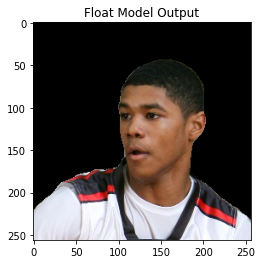

In [20]:
image=np.array(Image.open('/content/port_0basketball-player-game-sport-159611.jpeg'))
mask=run_tflite_model(tflite_file='/content/model-optimization/mnv3_seg_float.tflite',test_image=image)
crop_float=image*mask[...,np.newaxis]
plt.imshow(crop_float)
plt.title('Float Model Output')
plt.show()

Run the **quantization aware trained model** on test image and plot the results.

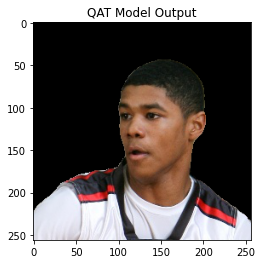

In [21]:
image=np.array(Image.open('/content/port_0basketball-player-game-sport-159611.jpeg'))
mask=run_tflite_model(tflite_file='/content/model-optimization/mnv3_seg_quant.tflite',test_image=image)
crop_qat=image*mask[...,np.newaxis]
plt.imshow(crop_qat)
plt.title('QAT Model Output')
plt.show()

Run the **post training quantized model** on test image and plot the results.

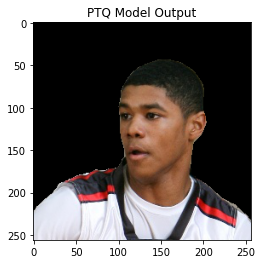

In [22]:
image=np.array(Image.open('/content/port_0basketball-player-game-sport-159611.jpeg'))
mask=run_tflite_model(tflite_file='/content/model-optimization/mnv3_post_quant.tflite',test_image=image)
crop_ptq=image*mask[...,np.newaxis]
plt.imshow(crop_ptq)
plt.title('PTQ Model Output')
plt.show()

Run the **post training quantization aware model** on test image and plot the results.

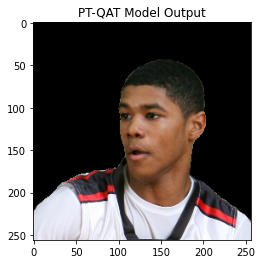

In [26]:
image=np.array(Image.open('/content/port_0basketball-player-game-sport-159611.jpeg'))
mask=run_tflite_model(tflite_file='/content/model-optimization/mnv3_post_quant_aware.tflite',test_image=image)
crop_ptq=image*mask[...,np.newaxis]
plt.imshow(crop_ptq)
plt.title('PT-QAT Model Output')
plt.show()

**References:-**



1.   https://www.tensorflow.org/install/source#setup_for_linux_and_macos
2.   https://www.tensorflow.org/model_optimization/guide/install
3. https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/applications/mobilenet_v3.py
4. https://www.tensorflow.org/model_optimization/guide/quantization/training_example
5. https://www.tensorflow.org/lite/performance/post_training_integer_quant
6. https://github.com/tensorflow/tensorflow/issues/42082
7. https://github.com/HasnainRaz/SemSegPipeline
8. https://github.com/tensorflow/tensorflow/issues/42082

